In [153]:
import auraloss
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch

import cnn
import synth

n_densities = 7
n_slopes = 7
n_folds = n_densities * n_slopes
batch_size = 1

dataset = cnn.ChirpTextureDataModule(
    n_densities=n_densities,
    n_slopes=n_slopes,
    n_folds=n_folds,
    batch_size=batch_size)
dataset.setup()

mss = auraloss.freq.MultiResolutionSTFTLoss()


CQT kernels created, time used = 0.0294 seconds
CQT kernels created, time used = 0.0222 seconds
CQT kernels created, time used = 0.0193 seconds


In [154]:
for seed in [0, 1]:

    y = synth.generate_chirp_texture(
            theta_density=torch.tensor(0.5),
            theta_slope=torch.tensor(0.),
            duration=dataset.train_ds.duration,
            event_duration=dataset.train_ds.event_duration,
            sr=dataset.train_ds.sr,
            fmin=dataset.train_ds.fmin,
            fmax=dataset.train_ds.fmax,
            n_events=dataset.train_ds.n_events,
            Q=dataset.train_ds.Q,
            hop_length=dataset.train_ds.hop_length,
            seed=seed,
        )

    X = {}
    mss_D = np.zeros((n_densities, n_slopes))
    mss_df = pd.DataFrame(columns=[
        "density_idx", "slope_idx", "distance", "density_grad", "slope_grad"])
    for _, row in dataset.df.iterrows():
        theta_density = torch.tensor(row["density"], requires_grad=True)
        theta_slope = torch.tensor(row["slope"], requires_grad=True)
        x = synth.generate_chirp_texture(
            theta_density=theta_density,
            theta_slope=theta_slope,
            duration=dataset.train_ds.duration,
            event_duration=dataset.train_ds.event_duration,
            sr=dataset.train_ds.sr,
            fmin=dataset.train_ds.fmin,
            fmax=dataset.train_ds.fmax,
            n_events=dataset.train_ds.n_events,
            Q=dataset.train_ds.Q,
            hop_length=dataset.train_ds.hop_length,
            seed=0,
        )
        xy_dist = mss(x.unsqueeze(0).unsqueeze(0), y.unsqueeze(0).unsqueeze(0))
        mss_D[int(row['density_idx']), int(row['slope_idx'])] = xy_dist
        xy_dist.backward()
        if theta_density.grad is None:
            theta_density.grad = torch.zeros_like(theta_density)
        if theta_slope.grad is None:
            theta_slope.grad = torch.zeros_like(theta_slope)
        mss_row = {
            "density_idx": int(row['density_idx']),
            "slope_idx": int(row['slope_idx']),
            "distance": xy_dist.item(),
            "density_grad": -theta_density.grad.item(),
            "slope_grad": -theta_slope.grad.item(),
        }
        mss_df.loc[len(mss_df)] = mss_row

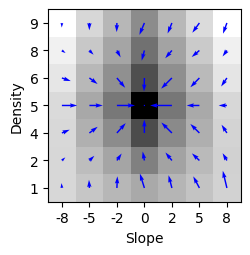

In [156]:
side_length = 2.5
plt.figure(figsize=(side_length, side_length))
plt.imshow(mss_D, cmap='gray')
plt.quiver(
    mss_df['density_idx'], mss_df['slope_idx'],
    mss_df['density_grad'], mss_df['slope_grad'],
    color='blue'
)
plt.xlabel('Slope')
plt.xticks(np.arange(n_slopes))
plt.gca().set_xticklabels([
    "{:.0f}".format(10*xt) for xt in
    np.linspace(-1, 1, n_slopes+2)[1:-1]])
plt.yticks(np.arange(n_slopes))
plt.gca().set_yticklabels([
    "{:.0f}".format(10*xt) for xt in
    np.linspace(0, 1, n_densities+2)[1:-1]])
plt.ylabel('Density')
plt.gca().invert_yaxis()

In [129]:
mss_df

,density_idx,slope_idx,distance,density_grad,slope_grad
0,0,0,1.764033,0.221952,-0.806022
1,0,1,1.648827,-0.382971,-0.448796
2,0,2,1.566881,-0.824355,-0.385892
3,0,3,1.486736,-1.366098,-0.411715
4,0,4,1.423097,-2.136246,0.000000
...,...,...,...,...,...
76,8,4,1.155827,0.838042,0.000000
77,8,5,1.431307,0.567205,1.376913
78,8,6,1.660099,0.432471,1.030004
79,8,7,1.870291,0.392078,1.342128


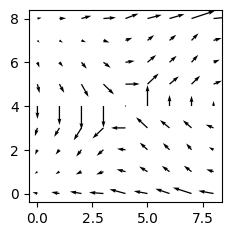

In [130]:
plt.figure(figsize=(2.5, 2.5))
plt.quiver(
    mss_df['density_idx'], mss_df['slope_idx'],
    mss_df['slope_grad'], mss_df['density_grad'],
)

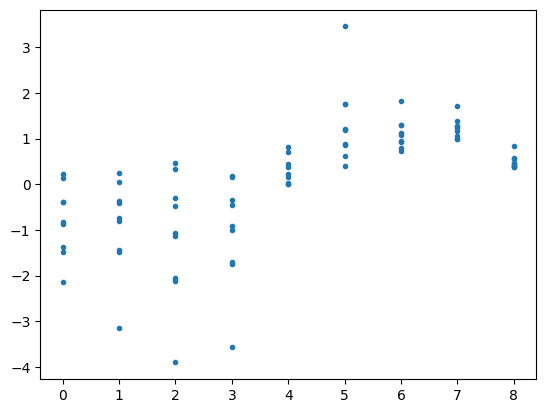

In [116]:
plt.plot(mss_df['density_idx'], mss_df['density_grad'], '.')

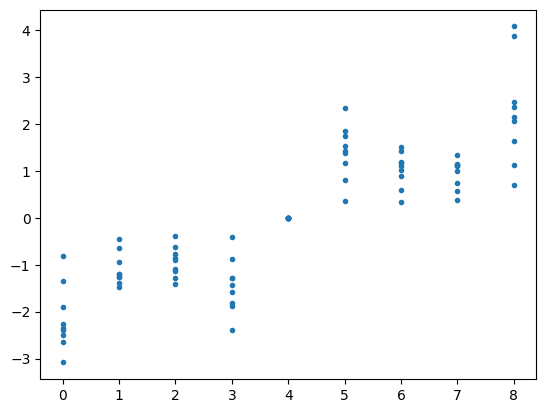

In [117]:
plt.plot(mss_df['slope_idx'], mss_df['slope_grad'], '.')